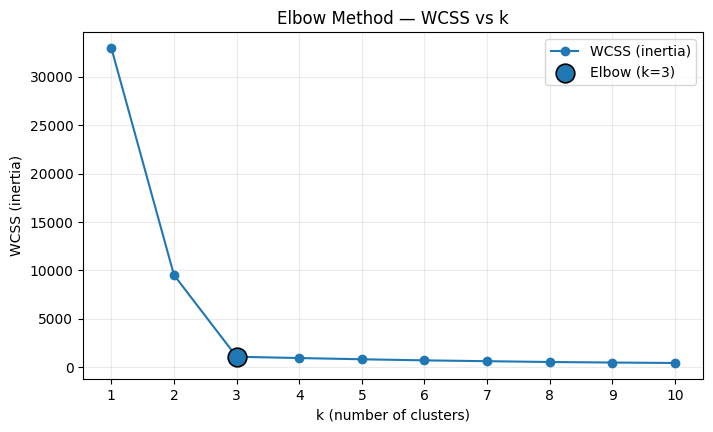

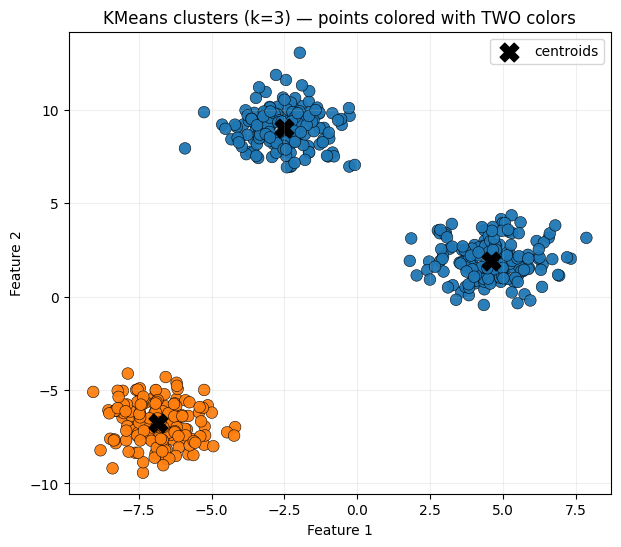

Detected elbow (distance-to-line method): k = 3

k	WCSS		Silhouette (k>=2)
 1	32988.32		-
 2	9510.84		0.6991
 3	1053.60		0.8359
 4	920.86		0.6656
 5	793.86		0.4982
 6	680.54		0.3274
 7	595.21		0.3427
 8	511.91		0.3606
 9	454.99		0.3455
10	410.86		0.3555


In [4]:
# k-means_elbow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------- Settings --------------------
np.random.seed(42)
n_samples = 500
true_centers = 3       # create data that actually has 3 blobs (so elbow approx 3)
max_k = 10

# -------------------- 1) Generate data --------------------
# Using make_blobs (random-number-based generator). we can replace this by random.randn if we prefer.
X, y_true = make_blobs(n_samples=n_samples, centers=true_centers, cluster_std=1.05, random_state=42)

# -------------------- 2) Run K-Means for k = 1..max_k and collect metrics --------------------
wcss = []           # within-cluster sum of squares (aka inertia)
sil_scores = [None] # silhouette not defined for k=1; keep index aligned
models = {}

for k in range(1, max_k + 1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    models[k] = km
    wcss.append(km.inertia_)
    if k >= 2:
        sil_scores.append(silhouette_score(X, km.labels_))

# -------------------- 3) Detect elbow using distance-to-line (no kneed) --------------------
# Idea: for points (k, wcss) compute distance to line from first to last; the farthest point is the elbow.
ks = np.arange(1, max_k + 1)
points = np.column_stack((ks, wcss))
p1 = points[0]
p2 = points[-1]

def point_line_distance(pt, a, b):
    # 2D distance from pt to line through a-b
    num = abs((b[1]-a[1])*pt[0] - (b[0]-a[0])*pt[1] + b[0]*a[1] - b[1]*a[0])
    den = np.hypot(b[1]-a[1], b[0]-a[0])
    return num / den if den != 0 else 0.0

dists = np.array([point_line_distance(pt, p1, p2) for pt in points])
elbow_index = dists.argmax()         # index in 0-based (corresponds to ks)
elbow_k = int(ks[elbow_index])

# -------------------- 4) Plot WCSS and mark elbow --------------------
plt.figure(figsize=(8,4.5))
plt.plot(ks, wcss, marker='o', linestyle='-', label='WCSS (inertia)')
plt.scatter([elbow_k], [wcss[elbow_index]], s=180, edgecolor='k', linewidth=1.2, zorder=5,
            label=f'Elbow (k={elbow_k})')
plt.xticks(ks)
plt.xlabel('k (number of clusters)')
plt.ylabel('WCSS (inertia)')
plt.title('Elbow Method — WCSS vs k')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# -------------------- 5) Fit chosen K and plot clusters colored using TWO colors --------------------
chosen_k = elbow_k
km_chosen = models[chosen_k]
labels = km_chosen.labels_
centers = km_chosen.cluster_centers_

# You requested two colors. If chosen_k > 2 we'll cycle two base colors so
# visually only two colors are used (tab:blue & tab:orange).
base_colors = ['tab:blue', 'tab:orange']
colors = [base_colors[l % len(base_colors)] for l in labels]

plt.figure(figsize=(7,6))
plt.scatter(X[:,0], X[:,1], c=colors, s=70, edgecolor='k', linewidth=0.4, alpha=0.95)
plt.scatter(centers[:,0], centers[:,1], marker='X', s=180, c='black', label='centroids')
plt.title(f'KMeans clusters (k={chosen_k}) — points colored with TWO colors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# -------------------- 6) Print concise table of metrics --------------------
print("Detected elbow (distance-to-line method): k =", elbow_k)
print()
print("k\tWCSS\t\tSilhouette (k>=2)")
for i, k in enumerate(ks):
    sil = "-" if k == 1 else f"{sil_scores[k-1]:.4f}"
    print(f"{k:2d}\t{wcss[i]:.2f}\t\t{sil}")
